In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score

# Dataset

In [2]:
df = pd.read_csv("Data/data_comparing/Breast2classes.csv")
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V4861,V4862,V4863,V4864,V4865,V4866,V4867,V4868,V4869,V4870
0,1,-0.448,-0.296,-0.100,-0.177,-0.107,0.128,-0.110,-0.095,-0.076,...,0.519,-0.135,-0.211,0.122,-0.289,-0.014,0.183,0.002,-0.508,0.031
1,1,-0.480,-0.512,-0.031,-0.075,-0.104,-0.018,-0.234,-0.225,-0.094,...,-0.107,-0.164,-0.304,0.068,-0.352,0.143,-0.128,0.049,0.265,-0.378
2,1,-0.568,-0.411,-0.398,0.116,-0.092,0.001,-0.166,0.036,0.397,...,-0.066,0.073,0.268,0.079,0.045,-0.290,0.024,0.275,0.499,-0.356
3,1,-0.819,-0.267,0.023,-0.230,0.198,-0.409,-0.510,0.529,0.354,...,-0.149,0.316,0.010,-0.243,-0.204,-0.072,0.009,-0.028,0.620,-0.394
4,1,-0.112,-0.670,0.421,-0.190,0.032,0.291,0.281,0.310,0.056,...,0.047,-0.042,-0.304,-0.112,-0.475,0.160,0.133,-0.093,-0.609,-0.036


In [3]:
import pandas as pd
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif

selector = VarianceThreshold(threshold=0.1)
df_reduced_variance = selector.fit_transform(df)

X = df.drop('V1', axis=1)
y = df['V1']
selector = SelectKBest(score_func=f_classif, k=50)
df_reduced_kbest = selector.fit_transform(X, y)

In [9]:
df_reduced_kbest.shape

(77, 50)

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_reduced_kbest, y.values, test_size=0.2, random_state=42)

In [22]:
X_max = X_train.max(axis=0)
X_min = X_train.min(axis=0)
X_train_scale = (X_train - X_min)/(X_max - X_min)
X_test_scale = (X_test - X_min)/(X_max - X_min)

# Build Model

In [23]:
class Adaptive_Linear():
    def __init__(self, lr=0.001, epochs=10, gd_type='bgd', batch_size=None, threshold=0):
        valid_gd_types = ['bgd', 'sgd', 'mgd']
        if gd_type not in valid_gd_types:
            raise ValueError(f"Invalid gd_type. Expected one of {valid_gd_types}, but got '{gd_type}'.")
        if gd_type == "mgd" and batch_size == None:
            raise ValueError(f"With the SGD algorithm, batch_size is different from None")
        self.lr = lr
        self.w = None
        self.epochs = epochs
        self.losses = []
        self.gd_type = gd_type
        self.batch_size = batch_size
        self.threshold = threshold 
        
    def activation(self, z):
        return z

    def predict_prob(self, X):
        z = np.dot(X, self.w.T)
        return self.activation(z)

    def predict(self, X):
        y_hat = self.predict_prob(X)
        y_hat = np.where(y_hat >= self.threshold, 1, 0)
        return y_hat

    def loss(self, X, y):
        y_hat = self.predict_prob(X)
        delta = y - y_hat
        return np.mean(delta**2)

    def grad(self, X, y):
        y_hat = self.predict_prob(X)
        delta = y_hat - y
        dw = np.dot(X.T, delta)
        return dw.T

    def fit(self, X, y):
        X_bias = np.c_[np.ones(X.shape[0]), X]
        self.w = np.zeros((1, X_bias.shape[1]))
        for i in range(self.epochs):
            if self.gd_type == 'bgd':
                dw = self.grad(X_bias, y)
                self.w -= self.lr * dw
            elif self.gd_type == 'sgd':
                for i in range(X_bias.shape[0]):
                    xi = X_bias[i:i+1]
                    yi = y[i:i+1]
                    dw = self.grad(xi, yi)
                    self.w -= self.lr * dw
            elif self.gd_type == 'mgd':
                indices = np.random.permutation(X_bias.shape[0])
                X_shuffled = X_bias[indices]
                y_shuffled = y[indices]
                
                for i in range(0, X_bias.shape[0], self.batch_size):
                    xi_batch = X_shuffled[i:i+self.batch_size]
                    yi_batch = y_shuffled[i:i+self.batch_size]
                    dw = self.grad(xi_batch, yi_batch)
                    self.w -= self.lr * dw
            self.losses.append(self.loss(X_bias, y))

    def evaluate(self, X, y):
        X_bias = np.c_[np.ones(X.shape[0]), X]
        y_pred = self.predict(X_bias)
        print(f'Accuracy: {accuracy_score(y, y_pred)}')
        print(f'Recall: {recall_score(y, y_pred, average='macro', zero_division=0)}')
        print(f'Precision: {precision_score(y, y_pred, average='macro', zero_division=0)}')

## BGD

### Train

In [30]:
model = Adaptive_Linear(lr=0.0001, epochs=200, threshold=0)
model.fit(X_train_scale, y_train.reshape(-1, 1))

Accuracy: 0.5901639344262295
Recall: 0.5
Precision: 0.29508196721311475


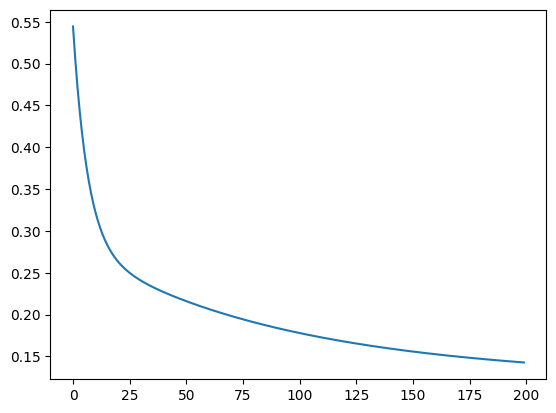

In [31]:
model.evaluate(X_train_scale, y_train)
plt.plot(model.losses)

### Test

In [32]:
model.evaluate(X_test_scale, y_test)

Accuracy: 0.5
Recall: 0.5
Precision: 0.25


## SGD

### Train

In [39]:
model = Adaptive_Linear(lr=0.0002, epochs=250, gd_type='sgd')
model.fit(X_train, y_train.reshape(-1, 1))

Accuracy: 0.6229508196721312
Recall: 0.54
Precision: 0.8050847457627119


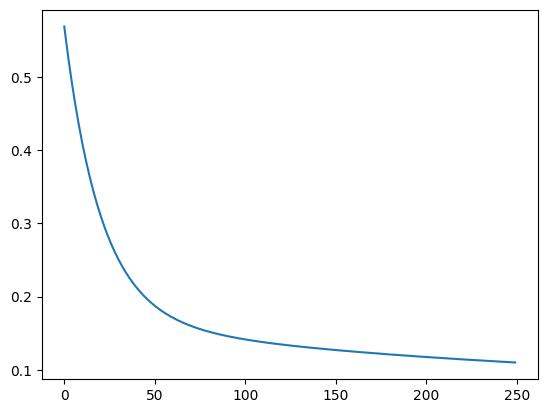

In [40]:
model.evaluate(X_train, y_train)
plt.plot(model.losses)

### Test

In [41]:
model.evaluate(X_test, y_test)

Accuracy: 0.5625
Recall: 0.5625
Precision: 0.7666666666666666


## MGD

### Train

In [60]:
model = Adaptive_Linear(lr=0.00002, epochs=1000, gd_type='mgd', batch_size=16)
model.fit(X_train, y_train.reshape(-1, 1))

Accuracy: 0.639344262295082
Recall: 0.56
Precision: 0.8103448275862069


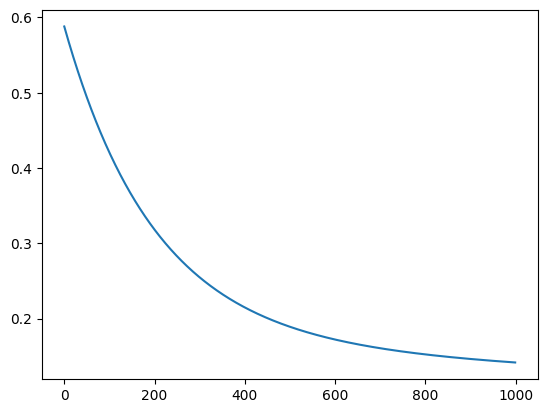

In [61]:
model.evaluate(X_train, y_train)
plt.plot(model.losses)

### Test

In [62]:
model.evaluate(X_test, y_test)

Accuracy: 0.5625
Recall: 0.5625
Precision: 0.7666666666666666
